<a href="https://colab.research.google.com/github/maira8009/Speech-Driven-Cardiac-Morbidity-Detection/blob/main/Speech2ECG_Multimodal_Cardiac_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
# ===== Step 0: Import Libraries =====
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# ===== Step 1: Load CSVs =====
speech_scaled = pd.read_csv(r'/content/speech_scaled.csv').values   # [43, 754]
generated_ecg = pd.read_csv(r'/content/generated_ecg.csv').values   # [43, 7]
labels_df = pd.read_csv(r'/content/ecg_labels.csv')

In [3]:

# Map string labels to integers
label_mapping = {'Normal': 0, 'AFib': 1, 'AbSin': 2}  # 3 classes
labels = labels_df['label'].map(label_mapping).values
labels_tensor = torch.tensor(labels, dtype=torch.long)

In [4]:
# ===== Step 2: Reduce Speech Feature Dimensionality with PCA =====
n_samples = speech_scaled.shape[0]
pca_components = min(30, n_samples)  # ≤ number of samples
pca = PCA(n_components=pca_components)
speech_pca = pca.fit_transform(speech_scaled)

In [5]:
# ===== Step 3: Fuse Features =====
fusion_features = np.concatenate([speech_pca, generated_ecg], axis=1)
fusion_tensor = torch.tensor(fusion_features, dtype=torch.float32)

print(f"Fused features shape: {fusion_tensor.shape}, Labels shape: {labels_tensor.shape}")

Fused features shape: torch.Size([43, 37]), Labels shape: torch.Size([43])


In [6]:
# ===== Step 4: Dataset Class =====
class FusionDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

full_dataset = FusionDataset(fusion_tensor, labels_tensor)

In [15]:
class FusionClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(FusionClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, num_classes)
        )
    def forward(self, x):
        return self.model(x)

input_dim = fusion_tensor.shape[1]
num_classes = 3


--- Fold 1 ---
Fold 1 Accuracy: 33.33%
Precision per class: [0.45454545 0.         0.        ]
Recall per class:    [0.55555556 0.         0.        ]
F1-score per class:  [0.5 0.  0. ]


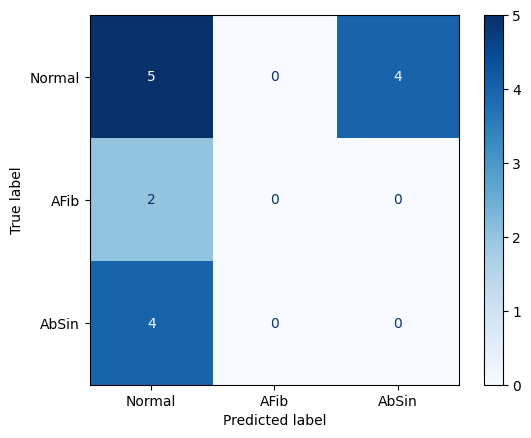


--- Fold 2 ---
Fold 2 Accuracy: 64.29%
Precision per class: [0.66666667 1.         0.        ]
Recall per class:    [0.88888889 1.         0.        ]
F1-score per class:  [0.76190476 1.         0.        ]


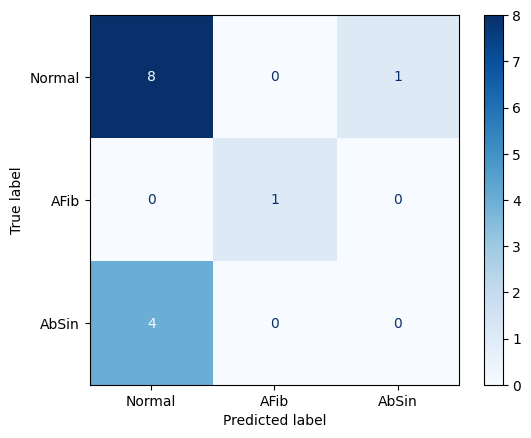


--- Fold 3 ---
Fold 3 Accuracy: 50.00%
Precision per class: [0.66666667 0.5        0.        ]
Recall per class:    [0.75 0.5  0.  ]
F1-score per class:  [0.70588235 0.5        0.        ]


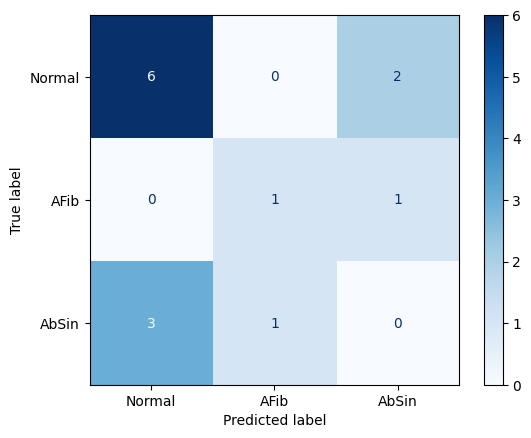


===== Cross-Validation Summary =====
Mean Accuracy: 49.21% ± 12.65%
Mean Precision per class: [0.5959596 0.5       0.       ]
Mean Recall per class:    [0.73148148 0.5        0.        ]
Mean F1-score per class:  [0.65592904 0.5        0.        ]


In [22]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1s = []

for fold, (train_idx, test_idx) in enumerate(kf.split(full_dataset)):
    print(f"\n--- Fold {fold+1} ---")

    train_subset = Subset(full_dataset, train_idx)
    test_subset = Subset(full_dataset, test_idx)

    train_loader = DataLoader(train_subset, batch_size=8, shuffle=True)
    test_loader = DataLoader(test_subset, batch_size=8, shuffle=False)

    # Initialize classifier for this fold
    classifier = FusionClassifier(input_dim, num_classes)

    # Weighted loss
    y_train_fold = labels_tensor[train_idx]
    class_counts = np.bincount(y_train_fold.numpy())
    total = sum(class_counts)
    # Handle cases where a class might be missing in a train fold
    class_weights = [total / c if c > 0 else 0.0 for c in class_counts]
    class_weights = torch.tensor(class_weights, dtype=torch.float32)

    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(classifier.parameters(), lr=0.001)

    # Train
    epochs = 100
    for epoch in range(epochs):
        classifier.train()
        for batch_features, batch_labels in train_loader:
            optimizer.zero_grad()
            outputs = classifier(batch_features)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

    # Evaluate
    classifier.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_features, batch_labels in test_loader:
            outputs = classifier(batch_features)
            predicted_labels = torch.argmax(outputs, axis=1)
            all_preds.append(predicted_labels)
            all_labels.append(batch_labels)

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    # Compute metrics
    acc = accuracy_score(all_labels.numpy(), all_preds.numpy())
    precision = precision_score(all_labels.numpy(), all_preds.numpy(), average=None, zero_division=0)
    recall = recall_score(all_labels.numpy(), all_preds.numpy(), average=None, zero_division=0)
    f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average=None, zero_division=0)

    fold_accuracies.append(acc)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1s.append(f1)

    print(f"Fold {fold+1} Accuracy: {acc*100:.2f}%")
    print(f"Precision per class: {precision}")
    print(f"Recall per class:    {recall}")
    print(f"F1-score per class:  {f1}")

    # Confusion matrix
    cm = confusion_matrix(all_labels.numpy(), all_preds.numpy(), labels=range(num_classes))
    disp = ConfusionMatrixDisplay(cm, display_labels=['Normal','AFib','AbSin'])
    disp.plot(cmap='Blues')
    plt.show()

# ===== Step 7: Summary Metrics =====
mean_acc = np.mean(fold_accuracies)
std_acc = np.std(fold_accuracies)
mean_precision = np.mean(fold_precisions, axis=0)
mean_recall = np.mean(fold_recalls, axis=0)
mean_f1 = np.mean(fold_f1s, axis=0)

print("\n===== Cross-Validation Summary =====")
print(f"Mean Accuracy: {mean_acc*100:.2f}% \u00b1 {std_acc*100:.2f}%")
print(f"Mean Precision per class: {mean_precision}")
print(f"Mean Recall per class:    {mean_recall}")
print(f"Mean F1-score per class:  {mean_f1}")

In [23]:
# ===== Step 7: Summary =====
mean_acc = np.mean(fold_accuracies)
std_acc = np.std(fold_accuracies)
print(f"\nMean CV Accuracy: {mean_acc*100:.2f}% ± {std_acc*100:.2f}%")


Mean CV Accuracy: 49.21% ± 12.65%
